## CNN model running for 56K records,  classification into first-level icd9-codes

In [1]:
%matplotlib inline
# General imports
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt


#keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom functions
%load_ext autoreload
%autoreload 2
import database_selection
import vectorization
import helpers
import icd9_cnn_model
import lstm_model


Using TensorFlow backend.


## Reading Input File

In [2]:
#reading file
full_df = pd.read_csv('../data/disch_notes_all_icd9.csv',
                 names = ['HADM_ID', 'SUBJECT_ID', 'DATE', 'ICD9','TEXT'])


In [3]:
full_df.shape

(52696, 5)

In [4]:
# taking just a subset of the records for developing models
#df = full_df.sample(frac=0.1).reset_index(drop=True)
df = full_df
print df.shape
df.head(10)

(52696, 5)


,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,100001,58526,2117-09-17 00:00:00,25013 3371 5849 5780 25063 5363 4580 25043 403...,Admission Date: [**2117-9-11**] ...
1,100003,54610,2150-04-21 00:00:00,53100 2851 07054 5715 45621 53789 4019 53550 7823,Admission Date: [**2150-4-17**] ...
2,100006,9895,2108-04-17 00:00:00,49320 51881 486 20300 2761 7850 3090,Admission Date: [**2108-4-6**] Discharg...
3,100007,23018,2145-04-07 00:00:00,56081 5570 9973 486 4019,Admission Date: [**2145-3-31**] ...
4,100009,533,2162-05-21 00:00:00,41401 99604 4142 25000 27800 4148 4111 2859 40...,Admission Date: [**2162-5-16**] ...
5,100010,55853,2109-12-14 00:00:00,1890 1961 1987 1976 27652,Admission Date: [**2109-12-10**] ...
6,100011,87977,2177-09-12 00:00:00,85206 82111 86403 48242 8600 2851 86121 80703 ...,Admission Date: [**2177-8-29**] ...
7,100012,60039,2177-03-22 00:00:00,41401 99811 4139 4019 2720,Admission Date: [**2177-3-12**] ...
8,100016,68591,2188-05-30 00:00:00,5070 51881 25541 47874 7580 34590 2512 45829 3...,Admission Date: [**2188-5-24**] ...
9,100018,58128,2176-09-06 00:00:00,2254 70723 4321 42833 3363 72271 99702 2761 74...,Admission Date: [**2176-8-29**] ...


## Pre processing ICD 9 codes

In [6]:
#Source: https://github.com/sirrice/icd9 plus doing queries with it
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df['ICD9'] = df['ICD9'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df.head(10)

,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,100001,58526,2117-09-17 00:00:00,240-279 390-459 680-709 520-579 320-389 580-629,Admission Date: [**2117-9-11**] ...
1,100003,54610,2150-04-21 00:00:00,001-139 780-789 390-459 290-319 520-579,Admission Date: [**2150-4-17**] ...
2,100006,9895,2108-04-17 00:00:00,240-279 780-789 140-239 290-319 460-519,Admission Date: [**2108-4-6**] Discharg...
3,100007,23018,2145-04-07 00:00:00,390-459 460-519 520-579 800-999,Admission Date: [**2145-3-31**] ...
4,100009,533,2162-05-21 00:00:00,240-279 390-459 290-319 800-999,Admission Date: [**2162-5-16**] ...
5,100010,55853,2109-12-14 00:00:00,240-279 140-239,Admission Date: [**2109-12-10**] ...
6,100011,87977,2177-09-12 00:00:00,290-319 460-519 800-999,Admission Date: [**2177-8-29**] ...
7,100012,60039,2177-03-22 00:00:00,240-279 390-459 800-999,Admission Date: [**2177-3-12**] ...
8,100016,68591,2188-05-30 00:00:00,240-279 760-779 390-459 290-319 460-519 520-57...,Admission Date: [**2188-5-24**] ...
9,100018,58128,2176-09-06 00:00:00,240-279 760-779 390-459 680-709 460-519 520-57...,Admission Date: [**2176-8-29**] ...


In [7]:
#counts by icd9_codes
icd9_codes = Counter()
for label in df['ICD9']:
    for icd9_code in label.split():
        icd9_codes[icd9_code] += 1
number_icd9_first_level = len (icd9_codes)
print icd9_codes
print 'Number of icd9 codes in the first level that have notes in the dataset:', number_icd9_first_level

Counter({'390-459': 41335, '240-279': 34600, '290-319': 27838, '460-519': 24577, '800-999': 21865, '580-629': 21253, '520-579': 20430, '780-789': 16270, '320-389': 15377, '001-139': 14212, '710-739': 9808, '140-239': 8579, '680-709': 5924, '760-779': 5454, '790-796': 4510, '799': 1624, '630-679': 156, '798': 1})
Number of icd9 codes in the first level that have notes in the dataset: 18


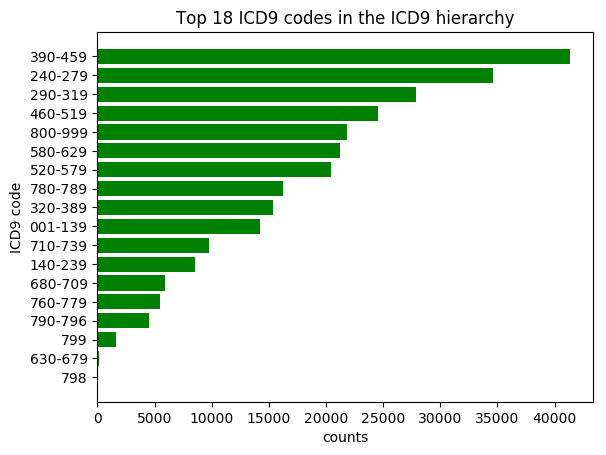

In [8]:
codes_counts =icd9_codes.items()
codes_counts.sort(key=itemgetter(1), reverse=True)
icd9_labels, values = zip(*codes_counts)
indexes = np.arange(len(icd9_labels))
plt.rcdefaults()
fig,ax = plt.subplots()
ax.barh(indexes, values,  align='center', color='green', ecolor='black')
ax.set_yticks(indexes)
ax.set_yticklabels(icd9_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top ' + str(number_icd9_first_level) + ' ICD9 codes in the ICD9 hierarchy')
plt.show()

In [9]:
#preprocess icd9 codes to vectors 
top_codes = ICD9_FIRST_LEVEL
labels = vectorization.vectorize_icd_column(df, 'ICD9', top_codes)
print 'sample of vectorized icd9 labels: ', labels[0]


sample of vectorized icd9 labels:  [0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0]


## Pre process Notes

In [10]:
#preprocess notes
MAX_VOCAB = None # to limit original number of words (None if no limit)
MAX_SEQ_LENGTH = 5000 # to limit length of word sequence (None if no limit)
df.TEXT = vectorization.clean_notes(df, 'TEXT')
data_vectorized, dictionary, MAX_VOCAB = vectorization.vectorize_notes(df.TEXT, MAX_VOCAB, verbose = True)
data, MAX_SEQ_LENGTH = vectorization.pad_notes(data_vectorized, MAX_SEQ_LENGTH)

print("Final Vocabulary: %s" % MAX_VOCAB)
print("Final Max Sequence Length: %s" % MAX_SEQ_LENGTH)

Vocabulary size: 139074
Average note length: 1634.982845
Max note length: 10924
Final Vocabulary: 139074
Final Max Sequence Length: 5000


In [12]:
#creating glove embeddings
EMBEDDING_DIM = 100 # given the glove that we chose
EMBEDDING_MATRIX= []
EMBEDDING_LOC = '../data/notes.100.txt' # location of embedding
EMBEDDING_MATRIX, embedding_dict = vectorization.embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True, sigma=True)


('Vocabulary in notes:', 139074)
('Vocabulary in original embedding:', 21056)
('Vocabulary intersection:', 20640)


## Split Files

In [13]:
#split sets
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(
    data, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

('Train: ', (36887, 5000), (36887, 19))
('Validation: ', (10539, 5000), (10539, 19))
('Test: ', (5270, 5000), (5270, 19))


In [14]:
# Delete temporary variables to free some memory
del df, data, labels

## CNN for text classification

Based on the following papers and links:
* "Convolutional Neural Networks for Sentence Classification"   
* "A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification"
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py
* http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
* https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py

In [17]:
reload(icd9_cnn_model)
#### build model
model = icd9_cnn_model.build_icd9_cnn_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,
                             num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.5,
                             num_classes=N_TOP )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 5000, 100)     13907500    input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 4999, 100)     20100       embedding_1[0][0]                
____________________________________________________________________________________________________
conv1d_6 (Conv1D)                (None, 4998, 100)     30100       embedding_1[0][0]                
___________________________________________________________________________________________

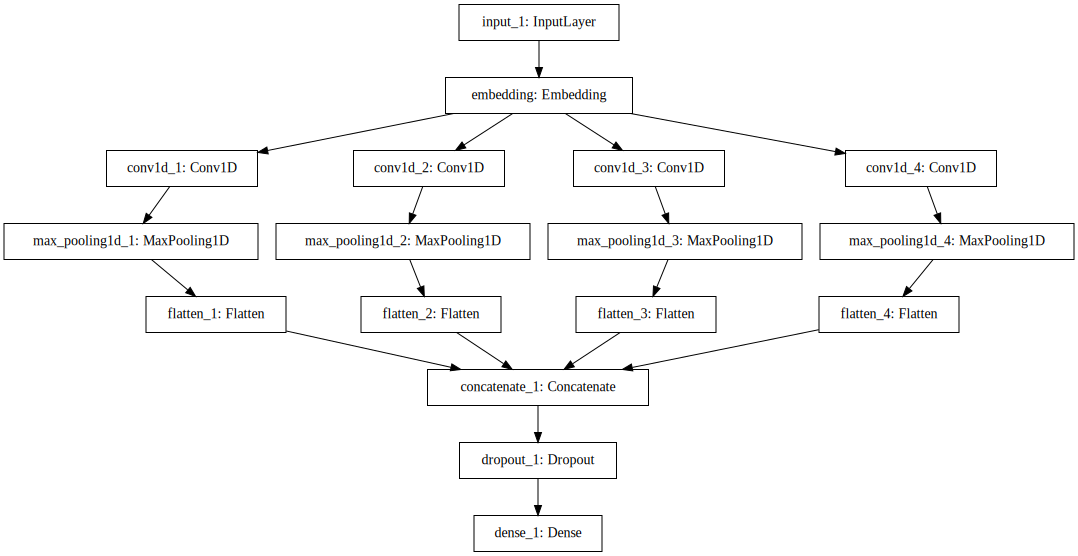

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=10, validation_data=(X_val, y_val), verbose=1)

Train on 36887 samples, validate on 10539 samples
Epoch 1/10
36887/36887 [==============================] - 1053s - loss: 0.4198 - acc: 0.8092 - val_loss: 0.3172 - val_acc: 0.8585

In [19]:
pred_train = model.predict(X_train, batch_size=50)
pred_dev = model.predict(X_val, batch_size=50)
# perform evaluation
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.589      0.582
0.030:      0.619      0.607
0.040:      0.645      0.628
0.050:      0.669      0.647
0.055:      0.679      0.655
0.058:      0.685      0.660
0.060:      0.689      0.663
0.080:      0.724      0.690
0.100:      0.753      0.712
0.200:      0.840      0.771
0.300:      0.874      0.792
0.400:      0.884      0.797
0.500:      0.879      0.791
0.600:      0.863      0.780
0.700:      0.838      0.760


In [21]:
model.save('models/cnn_50K_10_epochs.h5')
#model = load_model('models/cnn_20_epochs.h5')
